In [1]:
import numpy as np
import pandas as pd
from plotly.subplots import make_subplots
import plotly.graph_objects as go

import src.data.breathe_data as bd
import src.data.helpers as dh
import src.inference.helpers as ih
import src.modelling_ar.ar as ar
import src.inf_cutset_conditioning.helpers as cutseth
import src.inf_cutset_conditioning.cutset_cond_algs_learn_ar_change as cca_ar_change
import src.models.helpers as mh

In [2]:
# Load data
df = bd.load_meas_from_excel("BR_O2_FEV1_FEF2575_conservative_smoothing_with_idx")

INFO:root:* Checking for same day measurements *


In [5]:
id = "527"
dftmp, start_idx, end_idx = dh.find_longest_consec_series(df[df.ID == id], n_days=1)


ecfev1_noise_model_suffix = "_std_0.068"
ar_prior = "breathe (2 days model, ecFEV1 addmultnoise, ecFEF25-75)"
ar_change_cpt_suffix = "_shape_factor"

(
    # p_M_given_D,
    # log_p_D_given_M,
    # AR_given_M_and_D,
    # AR_given_M_and_all_D,
    log_p_S_given_D,
    res_dict,
) = cca_ar_change.run_long_noise_model_through_time(
    dftmp,
    ar_prior=ar_prior,
    ar_change_cpt_suffix=ar_change_cpt_suffix,
    ecfev1_noise_model_suffix=ecfev1_noise_model_suffix,
)

# 5.61 for 4 entries without
# 5.40 when removing AR calculations

527 - Time for 4 entries: 4.71 s


In [4]:
a = np.exp(log_p_S_given_D - log_p_S_given_D.max())
a / a.sum()

array([0.52396415, 0.22609143, 0.12158996, 0.07596246, 0.05239201])

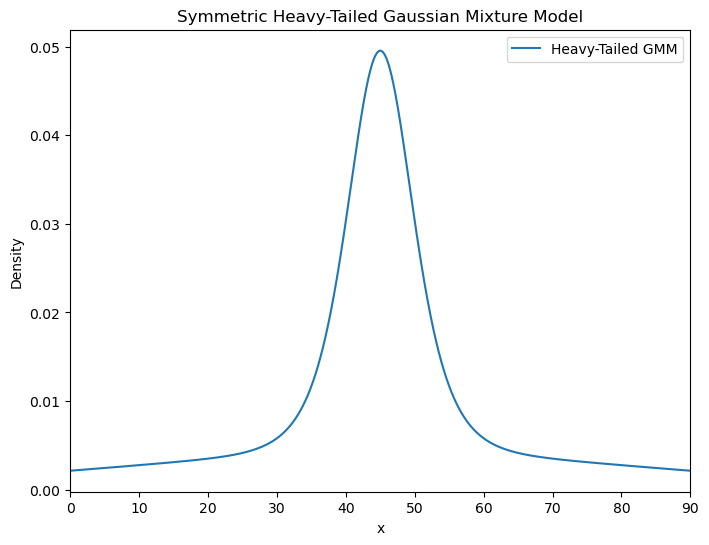

Means: [45, 45]
Scales: [5, 40]
Weights: [0.6, 0.4]


In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t, norm

# Define parameters for the mixture model
means = [45, 45]  # Adding more Gaussians for heavier tails
scales = [5, 40]  # Broader components for heavier tails
weights = [0.6, 0.4]  # 80% of mass in the center, lighter tails

def gmm_pdf(x, means, scales, weights, df=5):
    """ Compute the GMM PDF using a heavy-tailed t-distribution and multiple Gaussians. """
    pdf = np.zeros_like(x)
    pdf += weights[0] * t.pdf(x, df, loc=means[0], scale=scales[0])  # Main heavy-tailed component
    for mean, scale, weight in zip(means[1:], scales[1:], weights[1:]):
        pdf += weight * norm.pdf(x, mean, scale)  # Additional Gaussian components
    return pdf

# Generate x values for plotting
x_values = np.linspace(0, 90, 1000)

gmm_values = gmm_pdf(x_values, means, scales, weights)

# Plot the Gaussian Mixture Model
plt.figure(figsize=(8, 6))
plt.plot(x_values, gmm_values, label="Heavy-Tailed GMM")
plt.title("Symmetric Heavy-Tailed Gaussian Mixture Model")
plt.xlabel("x")
plt.ylabel("Density")
plt.legend()
plt.xlim(0, 90)
plt.show()

# Print defined parameters
print("Means:", means)
print("Scales:", scales)
print("Weights:", weights)


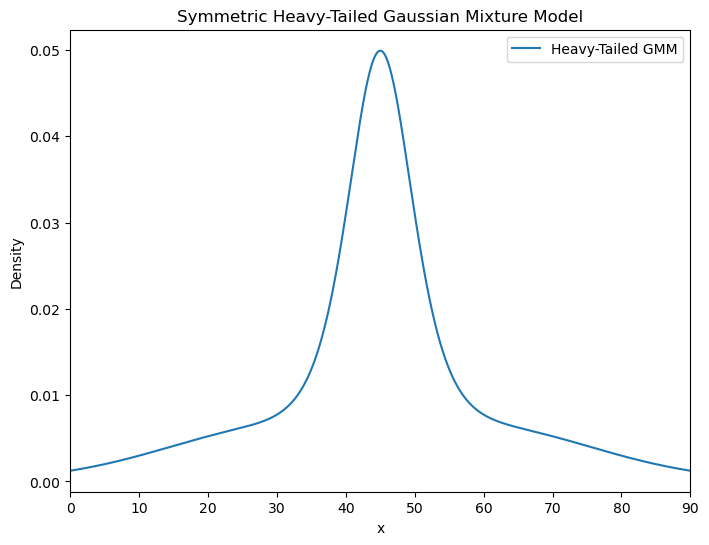

Means: [45, 30, 60, 20, 70]
Scales: [5, 12, 12, 15, 15]
Weights: [0.6, 0.1, 0.1, 0.1, 0.1]


In [26]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t, norm

# Define parameters for the mixture model
means = [45, 30, 60, 20, 70]  # Adding more Gaussians for heavier tails
scales = [5, 12, 12, 15, 15]  # Broader components for heavier tails
weights = [0.6, 0.1, 0.1, 0.1, 0.1]  # 80% of mass in the center, lighter tails

def gmm_pdf(x, means, scales, weights, df=5):
    """ Compute the GMM PDF using a heavy-tailed t-distribution and multiple Gaussians. """
    pdf = np.zeros_like(x)
    pdf += weights[0] * t.pdf(x, df, loc=means[0], scale=scales[0])  # Main heavy-tailed component
    for mean, scale, weight in zip(means[1:], scales[1:], weights[1:]):
        pdf += weight * norm.pdf(x, mean, scale)  # Additional Gaussian components
    return pdf

# Generate x values for plotting
x_values = np.linspace(0, 90, 1000)

gmm_values = gmm_pdf(x_values, means, scales, weights)

# Plot the Gaussian Mixture Model
plt.figure(figsize=(8, 6))
plt.plot(x_values, gmm_values, label="Heavy-Tailed GMM")
plt.title("Symmetric Heavy-Tailed Gaussian Mixture Model")
plt.xlabel("x")
plt.ylabel("Density")
plt.legend()
plt.xlim(0, 90)
plt.show()

# Print defined parameters
print("Means:", means)
print("Scales:", scales)
print("Weights:", weights)


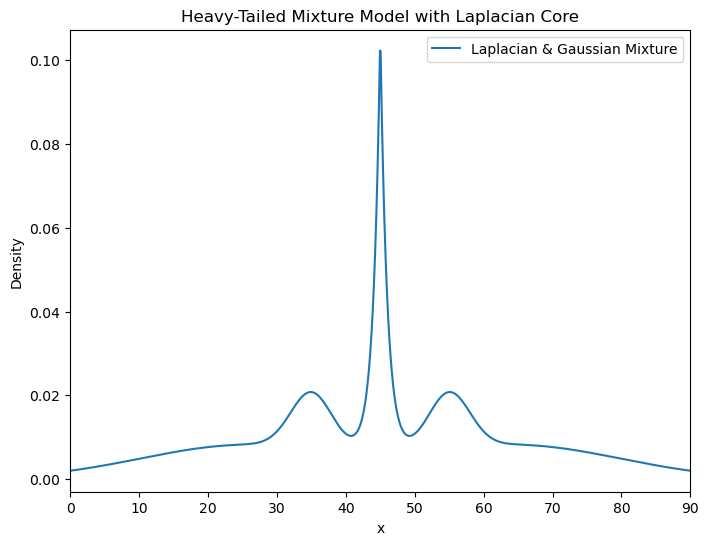

Means: [45, 55, 35, 25, 65]
Scales: [1, 3, 3, 15, 15]
Weights: [0.2, 0.1, 0.1, 0.3, 0.3]


In [28]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import laplace, norm

# Define parameters for the mixture model
means = [45, 55, 35, 25, 65]  # Adding more Gaussians for heavier tails
scales = [1, 3, 3, 15, 15]  # Narrowing Laplacian to emphasize side spikes
weights = [0.2, 0.1, 0.1, 0.3, 0.3]  # Main spike is 3 times higher than side spikes

def mixture_pdf(x, means, scales, weights):
    """ Compute the PDF using a Laplacian core and multiple Gaussians for heavy tails. """
    pdf = np.zeros_like(x)
    pdf += weights[0] * laplace.pdf(x, loc=means[0], scale=scales[0])  # Narrower Laplacian component
    for mean, scale, weight in zip(means[1:], scales[1:], weights[1:]):
        pdf += weight * norm.pdf(x, mean, scale)  # Additional Gaussian components
    
    return pdf

# Generate x values for plotting
x_values = np.linspace(0, 90, 1000)

mixture_values = mixture_pdf(x_values, means, scales, weights)

# Plot the Mixture Model
plt.figure(figsize=(8, 6))
plt.plot(x_values, mixture_values, label="Laplacian & Gaussian Mixture")
plt.title("Heavy-Tailed Mixture Model with Laplacian Core")
plt.xlabel("x")
plt.ylabel("Density")
plt.legend()
plt.xlim(0, 90)
plt.show()

# Print defined parameters
print("Means:", means)
print("Scales:", scales)
print("Weights:", weights)